Before reading this notebook, you may spend some time reading hello_keras.

In [28]:
import platform
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder, QuantileTransformer

from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.python.keras.metrics import AUC, Mean
from tensorflow.python.keras.models import load_model
from tensorflow import keras
import tensorflow as tf

from deepctr.layers import custom_objects
from deepctr.layers.utils import NoMask
from deepctr.feature_column import SparseFeat, get_feature_names, VarLenSparseFeat
from deepctr.models.multitask_modified.mmoe import MMOELayer, MMOE_BIAS
from deepctr.callbacks import EarlyStopping, Recorder, ModifiedExponentialDecay
from deepctr.models.multitask_modified.multitaskbase import MultiTaskModelBase
from deepctr.metrics import calc_lift

custom_objects['NoMask'] = NoMask
custom_objects['MMOELayer'] = MMOELayer
custom_objects['MultiTaskModelBase'] = MultiTaskModelBase
custom_objects['Mean'] = Mean
custom_objects['AUC'] = AUC
custom_objects['ModifiedExponentialDecay'] = ModifiedExponentialDecay

In [18]:
# configure system params
project_name = 'preloan_istrans_overdue'
run_name = 'uncertainty_bias_fpd4_mask_mob3_k11_mask7'
mode = 'train'
if platform.system() == 'Windows':
    joint_symbol = '\\'
else:
    joint_symbol = '/'
checkpoint_dir = joint_symbol.join([project_name, 'ckt', run_name])
tensorboard_dir = joint_symbol.join([project_name, 'log_dir', run_name])
summary_dir = joint_symbol.join([project_name, 'metrics', run_name])
trend_dir = joint_symbol.join([project_name, 'trend', run_name])
tasks = {'istrans': 'binary', 'fpd4': 'binary', 'mob3_k11': 'binary'}
loss_fns = {'istrans': keras.losses.binary_crossentropy,
            'fpd4': keras.losses.binary_crossentropy,
            'mob3_k11': keras.losses.binary_crossentropy}
# loss_fns = {'istrans': keras.losses.BinaryCrossentropy(),
#             'fpd4': keras.losses.BinaryCrossentropy()}
metrics_logger = {'istrans': AUC(name='istrans_AUC'),
                  'fpd4': AUC(name='fpd4_AUC'),
                  'mob3_k11': AUC(name='mob3_k11_AUC')}
loss_weights = {'istrans': 1, 'fpd4': 6, 'mob3_k11': 6}
bias_features = {'istrans': ['pre_loan_flag']}
bias_dropout_dict = {'istrans': 0.1, 'fpd4': 0.1}
if run_name.find('uncertainty') >= 0:
    uncertainty = True
else:
    uncertainty = False
if run_name.find('gradnorm') >= 0:
    gradnorm = True
else:
    gradnorm = False
if run_name.find('bias') >= 0:
    add_bias = True
else:
    add_bias = False
batch_size = 256

In [19]:
# read data and do some preprocessing
data = pd.read_csv('../data/multitask/multitask_demo.csv')
col_x = ['td_i_cnt_partner_all_imbank_365d',
         'duotou_br_als_m3_id_pdl_allnum',
         'marketing_channel_pred_1',
         'td_i_length_first_all_consumerfinance_365d',
         'duotou_br_als_m12_cell_nbank_allnum',
         'tx_m12_id_platnum',
         'duotou_br_als_m12_id_caon_allnum',
         'duotou_br_alf_apirisk_all_sum',
         'model_key_pred_1',
         'duotou_bh_rl_creditlimitsum',
         'dxm_dt_score',
         'credit_score_ronghuixf',
         'regist_channel_pred_1',
         'cs_mf_score_dt',
         'credit_score_sh',
         'duotou_br_als_m3_id_nbank_allnum',
         'br_frg_list_level',
         'td_3m_idcard_lending_cnt',
         'duotou_br_alf_apirisk_all_mean',
         'cs_hc_phone_score',
         'tx_m6_cell_allnum',
         'duotou_br_als_m12_id_pdl_allnum',
         'dxm_qzf',
         'ali_rain_score',
         'td_zhixin_score',
         'ab_local_cnt',
         'ab_mobile_cnt',
         'cust_id_area',
         'cust_gender',
         'immediate_relation_cnt',
         'hds_36m_month_max_purchase_money_excp_doub11_12',
         'ab_local_ratio',
         'hds_36m_purchase_steady',
         'cust_work_city',
         'relation_contact_cnt',
         'td_xyf_dq_score',
         'selffill_is_have_creditcard',
         'credit_repayment_score_bj_2',
         'bj_jc_m36_consume_cnt',
         'selffill_degree',
         'selffill_marital_status',
         'operation_sys',
         'hds_mobile_rich',
         'ab_prov_cnt',
         'hds_36m_total_purchase_cnt',
         'idcard_district_grade',
         'study_app_cnt',
         'hds_recent_consumme_active_rank',
         'hds_mobile_reli_rank',
         'hds_36m_doub11_12_total_purchase_money',
         'idcard_rural_flag']
data[col_x] = data[col_x].replace([-99, -1, np.nan, '-1', '-99', '-1111', '-999', -999], np.nan)
data['cust_gender'] = data['cust_gender'].map({'男': 0.0, '女': 1.0})
data['selffill_is_have_creditcard'] = data['selffill_is_have_creditcard'].map({'N': 0.0, 'Y': 1.0, '0': np.nan})
data['operation_sys'] = data['operation_sys'].replace(
    {'IOS': 'ios', 'iPhone OS': 'ios', 'iOS': 'ios', 'Android': 'android'})
data['operation_sys'] = data['operation_sys'].map({'ios': 0.0, 'android': 1.0})
data['hds_mobile_reli_rank'] = data['hds_mobile_reli_rank'].map({'M0': np.nan, 'Ma': 0.0, 'Mb': 1.0})

istrans: if the customer applies for a loan

fpd4: if the customer defaults in the first month

mob3_k11: if the customer defaults in the third month

Its's obvious that all the customers have 0/1 labels for istrans but not
all the customers have a label for fpd4, not to mention mob3_k11.

we use mask/weight=1 to enable the effective labels to back-propagate and mask/weight=0 otherwise.
Here "xxx_weight" indicates masks used in training & evaluation, and "xxx_mask" indicates masks used in inference.

In [20]:
data['fpd4_weight'] = 1.0
data['fpd4_mask'] = 1.0
if run_name.find('fpd4_nomask') >= 0:
    pass
else:
    data.loc[(data['if_t4'] != 1), 'fpd4_weight'] = 0.0
data.loc[(data['if_t4'] != 1), 'fpd4_mask'] = 0

data['mob3_k11_weight'] = 1.0
data['mob3_k11_mask'] = 1.0
if run_name.find('mob3_k11_nomask') >= 0:
    pass
else:
    data.loc[(data['if_mob3_t11'] != 1), 'mob3_k11_weight'] = 0.0
data.loc[(data['if_mob3_t11'] != 1), 'mob3_k11_mask'] = 0

data['istrans_weight'] = 1.0
data['istrans_mask'] = 1.0
data.loc[data['pre_loan_flag'] != 0, 'istrans_mask'] = 0.0
if run_name.find('istrans_mask') >= 0:
    data.loc[data['pre_loan_flag'] != 0, 'istrans_weight'] = 0.0

# just in case
data['fpd4'] = data['fpd4'].fillna(0)
data['mob3_k11'] = data['mob3_k11'].fillna(0)


Financial data makes good use of numerical features, but they are not friendly to DNN.
Just to show a fancy technique (and not to say it is needed in real modeling), we map features to uniform distribution in 0-1,
and then we cut them to buckets to enable the embedding power.

In [21]:
quantile_transformer = QuantileTransformer(random_state=0)
quantile_transformer.fit(data[(data['set'] == '1train') | (data['set'] == '2test')][col_x])
data[col_x] = quantile_transformer.transform(data[col_x])


Preloan is an indicator that a customer is aggressive in seeking money,
but this information may not be available at model scoring. So, we may model
the preloan effect as a logistic regression, and add up the effect to the other part.
By doing that, you may take off the preloan logistic logit and only use the other part as online model.

In [22]:
# generate input tensors
n_bins = 20
varlen_feature_columns = [VarLenSparseFeat(SparseFeat(col, vocabulary_size=n_bins+1, embedding_dim=4),
                                           maxlen=n_bins+1, combiner='sum', weight_name=col+'_weight')
                          for col in col_x]

dnn_feature_columns = varlen_feature_columns

if add_bias:
    bias_feature_columns_dict = {}
    bias_feature_columns_list = []
    for task_name, columns in bias_features.items():
        bias_feature_columns = [SparseFeat(feat, vocabulary_size=data[feat].unique().shape[0], embedding_dim=8)
                                for i, feat in enumerate(columns)]
        bias_feature_columns_list += bias_feature_columns
        bias_feature_columns_dict[task_name] = bias_feature_columns
    feature_names = get_feature_names(dnn_feature_columns + bias_feature_columns_list)
    bias_feature_names = get_feature_names(bias_feature_columns_list)
    for feat in bias_feature_names:
        lbe = LabelEncoder()
        data[feat] = lbe.fit_transform(data[feat])
else:
    bias_feature_columns_dict = None
    bias_dropout_dict = None
    bias_feature_names = []
    feature_names = get_feature_names(dnn_feature_columns)

1. Because features have been mapped to uniform distribution in 0-1, each feature
can be cut to n_bins buckets, and the centroid of each bucket will be: np.arange(1/(2*n_bins), 1+1/(2*n_bins), 1/n_bins).
Pre-append a bucket for missing values, so there are totally n_bins + 1 buckets.
2. Calculate the distances between a numerical value and the first n_bins centroids,
and use the reciprocals as weights. Use the weights to add up embeddings.
3. If a value is missing, only the first weight will be set to 1, and the other n_bins weights will be set to 0.

In [23]:
# generate input data for model
train = data[data['set'] == '1train']
test = data[data['set'] == '2test']
weight_dict = {}
for round_num, ft in enumerate(col_x):
    weight_dict[ft] = np.array([list(range(0, n_bins+1))]*train.shape[0])
    bin_ary = np.arange(1/(2*n_bins), 1+1/(2*n_bins), 1/n_bins)
    cent_hat = np.abs(np.expand_dims(np.expand_dims(train[ft], -1), -1) - np.expand_dims(bin_ary, -1))
    weight = 1.0 / (cent_hat + 1e-7)
    weight = weight / np.sum(weight, axis=1, keepdims=True)
    weight = np.concatenate([np.zeros((weight.shape[0], 1, 1)), weight], axis=1)
    nan_indicator = train[ft].isnull().values
    weight[nan_indicator, 1:, :] = 0.
    weight[nan_indicator, 0, :] = 1.
    weight_dict[ft+'_weight'] = weight
    assert(weight.shape[1]==21)
model_input = weight_dict
for ft in bias_feature_names:
    model_input[ft] = train[ft].values

weight_dict = {}
for round_num, ft in enumerate(col_x):
    weight_dict[ft] = np.array([list(range(0, n_bins+1))]*test.shape[0])
    bin_ary = np.arange(1/(2*n_bins), 1+1/(2*n_bins), 1/n_bins)
    cent_hat = np.abs(np.expand_dims(np.expand_dims(test[ft], -1), -1) - np.expand_dims(bin_ary, -1))
    weight = 1.0 / (cent_hat + 1e-7)
    weight = weight / np.sum(weight, axis=1, keepdims=True)
    weight = np.concatenate([np.zeros((weight.shape[0], 1, 1)), weight], axis=1)
    nan_indicator = test[ft].isnull().values
    weight[nan_indicator, 1:, :] = 0.
    weight[nan_indicator, 0, :] = 1.
    weight_dict[ft+'_weight'] = weight
    assert(weight.shape[1]==21)
test_model_input = weight_dict
for ft in bias_feature_names:
    test_model_input[ft] = test[ft].values

weight_dict = {}
for round_num, ft in enumerate(col_x):
    weight_dict[ft] = np.array([list(range(0, n_bins+1))]*train[ft].iloc[:1].shape[0])
    bin_ary = np.arange(1/(2*n_bins), 1+1/(2*n_bins), 1/n_bins)
    cent_hat = np.abs(np.expand_dims(np.expand_dims(train[ft].iloc[:1], -1), -1) - np.expand_dims(bin_ary, -1))
    weight = 1.0 / (cent_hat + 1e-7)
    weight = weight / np.sum(weight, axis=1, keepdims=True)
    weight = np.concatenate([np.zeros((weight.shape[0], 1, 1)), weight], axis=1)
    nan_indicator = train[ft].iloc[:1].isnull().values
    weight[nan_indicator, 1:, :] = 0.
    weight[nan_indicator, 0, :] = 1.
    weight_dict[ft+'_weight'] = weight
    assert(weight.shape[1]==21)
model_batch_input = weight_dict
for ft in bias_feature_names:
    model_batch_input[ft] = train[ft].iloc[:1].values

callback_data = (test_model_input,
                 {task_name: test[[task_name]] for task_name in tasks.keys()},
                 {task_name: test[task_name+'_weight'] for task_name in tasks.keys()})
callback_data = list(tf.data.Dataset.from_tensor_slices(callback_data).shuffle(test['istrans'].shape[0]).batch(
    batch_size).take(1))[0]

# train_dataset = tf.data.Dataset.from_tensor_slices((model_input,
#                                                     {'istrans': train['istrans'].values,
#                                                      'fpd4': train['fpd4'].values}))
# train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
# val_dataset = tf.data.Dataset.from_tensor_slices((test_model_input,
#                                                   {'istrans': test['istrans'].values,
#                                                    'fpd4': test['fpd4'].values}))
# val_dataset = val_dataset.batch(batch_size)

Multitask models suffer from the balance problem among different tasks.
You can use uncertainly weighting or gradnorm weighting to tackle the problem.
If gradnorm weighting is used, you should specify the last shared layer as grad monitor,
and that is the expert layer for mmoe. We provide a callback util, Recorder, for you
to monitor the grad.

* [Zhao Chen, Vijay Badrinarayanan, Chen-Yu Lee, Andrew Rabinovich.
GradNorm: Gradient Normalization for Adaptive Loss Balancing in Deep Multitask Networks.
Proceedings of the 35 th International Conference on Machine
Learning]()

* [Alex Kendall, Yarin Gal, Roberto Cipolla.
Multi-Task Learning Using Uncertainty to Weigh Losses for Scene Geometry and Semantics]()

In [24]:
# train
model = MMOE_BIAS(dnn_feature_columns,
                  tasks,
                  bias_feature_columns_dict,
                  bias_dropout_dict,
                  num_experts=4,
                  expert_dim=8,
                  bottom_shared_units=(96, 96),
                  bottom_shared_use_bn=False,
                  l2_reg_embedding=2.7618e-05,
                  l2_reg_dnn=1.1261e-05
                  )
# plot_model(aa, to_file=joint_symbol.join([checkpoint_dir, 'model_viz.png']), show_shapes=True,
#            show_layer_names=True)
if gradnorm:
    last_shared_weights = [weight for weight in model.get_layer('mmoe_layer').trainable_weights
                           if weight.name.find('expert') >= 0]
    gradnorm_config = {'alpha': 0.3, 'last_shared_weights': last_shared_weights}
else:
    gradnorm_config = None
# last_lr = 0.003
last_lr = 0.001
optimizers = keras.optimizers.Adam(learning_rate=ModifiedExponentialDecay(last_lr))
# multitask_modified = keras.multitask_modified.Adam(learning_rate=last_lr)
model.compile(optimizer=optimizers,
              loss=loss_fns,
              metrics=metrics_logger,
              loss_weights=loss_weights,
              uncertainly=uncertainty,
              gradnorm_config=gradnorm_config)
try:
    checkpoints = [joint_symbol.join([checkpoint_dir, name]) for name in os.listdir(checkpoint_dir)]
    latest_checkpoint = max(checkpoints).split('.index')[0]
    model.train_on_batch(model_batch_input,
                         {task_name: train[[task_name]].iloc[:1] for task_name in tasks.keys()})
    model.load_weights(latest_checkpoint)
    _, last_epoch, last_lr = latest_checkpoint.split('-')
    print('Restoring from ', latest_checkpoint)
    last_epoch = int(last_epoch)
    last_lr = float(last_lr)
except:
    print('Creating a new model')
    last_epoch = 0
print('last epoch', last_epoch)
print('last lr', last_lr)
history = model.fit(model_input,
                    {task_name: train[[task_name]] for task_name in tasks.keys()},
                    sample_weight={task_name: train[task_name+'_weight'] for task_name in tasks.keys()},
                    batch_size=256,
                    epochs=100,
                    initial_epoch=last_epoch,
                    verbose=2,
                    validation_data=(test_model_input,
                                     {task_name: test[[task_name]] for task_name in tasks.keys()},
                                     {task_name: test[task_name+'_weight'] for task_name in tasks.keys()}),
                    callbacks=[
                        # ReduceLROnPlateau(monitor='val_fpd4_AUC', factor=0.7, mode='max',
                        #                   patience=2, verbose=1, min_delta=0.01),
                              EarlyStopping('val_fpd4_AUC',
                                              patience=10,
                                              savepath=checkpoint_dir,
                                              coef_of_balance=0.4,
                                              direction='maximize'),
                              TensorBoard(log_dir=tensorboard_dir),
                              Recorder(log_dir=tensorboard_dir,
                                         data=callback_data)

                              ]
                    )


uncertainty: loss weights wont be used
Creating a new model
last epoch 0
last lr 0.001
Epoch 1/100
74/74 - 18s - total_loss: 1.3956 - istrans_AUC: 0.5298 - fpd4_AUC: 0.4944 - mob3_k11_AUC: 0.5004 - istrans_loss: 0.6714 - fpd4_loss: 0.3190 - mob3_k11_loss: 0.4030 - istrans_exp_log_var: 1.0364 - fpd4_exp_log_var: 1.0411 - mob3_k11_exp_log_var: 1.0405 - val_total_loss: 0.9228 - val_istrans_AUC: 0.6650 - val_fpd4_AUC: 0.5000 - val_mob3_k11_AUC: 0.5000 - val_istrans_loss: 0.6429 - val_fpd4_loss: 0.0906 - val_mob3_k11_loss: 0.1875 - val_istrans_exp_log_var: 1.0733 - val_fpd4_exp_log_var: 1.0883 - val_mob3_k11_exp_log_var: 1.0873
Epoch 2/100
74/74 - 2s - total_loss: 0.8563 - istrans_AUC: 0.6591 - fpd4_AUC: 0.5077 - mob3_k11_AUC: 0.5051 - istrans_loss: 0.6297 - fpd4_loss: 0.0600 - mob3_k11_loss: 0.1651 - istrans_exp_log_var: 1.1091 - fpd4_exp_log_var: 1.1320 - mob3_k11_exp_log_var: 1.1308 - val_total_loss: 0.7776 - val_istrans_AUC: 0.6650 - val_fpd4_AUC: 0.5000 - val_mob3_k11_AUC: 0.5000 - val

D:\ProgramData\Anaconda3\envs\python3.6_tf2\lib\site-packages\tensorflow\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [30]:
# load the best model
best_metric = -1
best_model = None
for i in os.listdir(checkpoint_dir):
    if i.find('best_model') >= 0:
        metric = float(re.match('.*AUC(.*).h5', i)[1])
        if metric > best_metric:
            best_metric = metric
            best_model = i
print('loading ', joint_symbol.join([checkpoint_dir, best_model]))
model = load_model(joint_symbol.join([checkpoint_dir, best_model]), compile=False, custom_objects=custom_objects)

loading  preloan_istrans_overdue\ckt\uncertainty_bias_fpd4_mask_mob3_k11_mask7\best_model_epoch39_val_fpd4_AUC0.7252.h5


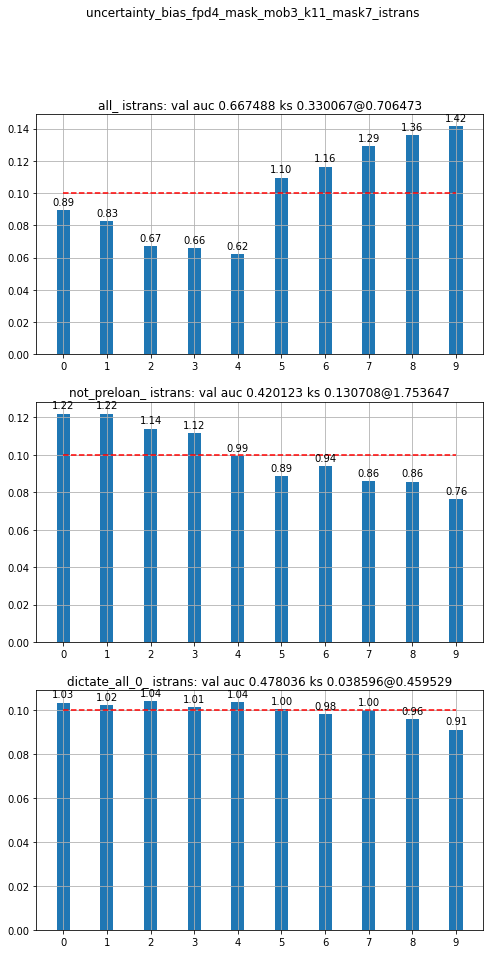

In [38]:
# explore the effect of pre_loan_flag
weight_dict = {}
for round_num, ft in enumerate(col_x):
    weight_dict[ft] = np.array([list(range(0, n_bins+1))]*test.shape[0])
    bin_ary = np.arange(1/(2*n_bins), 1+1/(2*n_bins), 1/n_bins)
    cent_hat = np.abs(np.expand_dims(np.expand_dims(test[ft], -1), -1) - np.expand_dims(bin_ary, -1))
    weight = 1.0 / (cent_hat + 1e-7)
    weight = weight / np.sum(weight, axis=1, keepdims=True)
    weight = np.concatenate([np.zeros((weight.shape[0], 1, 1)), weight], axis=1)
    nan_indicator = test[ft].isnull().values
    weight[nan_indicator, 1:, :] = 0.
    weight[nan_indicator, 0, :] = 1.
    weight_dict[ft+'_weight'] = weight
    assert(weight.shape[1]==21)
test_model_input = weight_dict
for ft in bias_feature_names:
    test_model_input[ft] = test[ft].values
    
for task_name in ['istrans']:
    fig = plt.figure(figsize=(8, 15))
    fig.suptitle(run_name + '_' + task_name)
    predictions = model.predict(test_model_input)
    pred = predictions[task_name][:, 0]
    target = test[task_name].values
    auc_score = roc_auc_score(target, pred,
                              # sample_weight=set_data[task_name + '_mask'].values
                              )
    fpr, tpr, thresholds = roc_curve(target, pred,
                                     # sample_weight=set_data[task_name + '_mask'].values
                                     )
    ks = np.max(np.abs(tpr - fpr))
    ks_index = np.argmax(tpr - fpr)
    ks_thresh = thresholds[ks_index]
    df = pd.DataFrame({'pred': pred, 'target': target})
    ax = fig.add_subplot(3, 1, 1)
    _ = calc_lift(df, 'pred', 'target', ax=ax, groupnum=10,
                  title_name='all_'+' {}: {} auc {:4f} ks {:4f}@{:4f}'.format(task_name, 'val', auc_score, ks, ks_thresh))

    weight = test[task_name + '_mask'].values
    auc_score = roc_auc_score(target, pred,
                              sample_weight=weight
                              )
    fpr, tpr, thresholds = roc_curve(target, pred,
                                     sample_weight=weight
                                     )
    ks = np.max(np.abs(tpr - fpr))
    ks_index = np.argmax(tpr - fpr)
    ks_thresh = thresholds[ks_index]
    ax = fig.add_subplot(3, 1, 2)
    df = pd.DataFrame({'pred': pred[weight != 0], 'target': target[weight != 0]})
    _ = calc_lift(df, 'pred', 'target', ax=ax, groupnum=10,
                  title_name='not_preloan_'+' {}: {} auc {:4f} ks {:4f}@{:4f}'.format(task_name, 'val', auc_score, ks, ks_thresh))

    test_model_input['pre_loan_flag'] = np.array([0]*test_model_input['pre_loan_flag'].shape[0])
    predictions = model.predict(test_model_input)
    pred = predictions[task_name][:, 0]
    target = test[task_name].values
    auc_score = roc_auc_score(target, pred,
                              # sample_weight=set_data[task_name + '_mask'].values
                              )
    fpr, tpr, thresholds = roc_curve(target, pred,
                                     # sample_weight=set_data[task_name + '_mask'].values
                                     )
    ks = np.max(np.abs(tpr - fpr))
    ks_index = np.argmax(tpr - fpr)
    ks_thresh = thresholds[ks_index]
    df = pd.DataFrame({'pred': pred, 'target': target})
    ax = fig.add_subplot(3, 1, 3)
    _ = calc_lift(df, 'pred', 'target', ax=ax, groupnum=10,
                  title_name='dictate_all_0_'+' {}: {} auc {:4f} ks {:4f}@{:4f}'.format(task_name, 'val', auc_score, ks, ks_thresh))
    plt.show()